In [1]:
from __future__ import division
from __future__ import print_function

import six
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten
# Merge is a layer, used to merge layers, merge is for tensors
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K
from sklearn.metrics import mean_squared_error

import numpy as np
np.random.seed(1337)

Using TensorFlow backend.


In [15]:
def _bn_relu(input):
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu(**conv_params):   # conv_params is a dictionary...
    nb_filter = conv_params["nb_filter"]
    nb_row = conv_params["nb_row"]
    nb_col = conv_params["nb_col"]
    subsample = conv_params.setdefault("subsample", (1, 1))
    init = conv_params.setdefault("init", "he_normal")
    border_mode = conv_params.setdefault("border_mode", "same")
    W_regularizer = conv_params.setdefault("W_regularizer", l2(1.e-4))
    def f(input):
        conv = Convolution2D(nb_filter=nb_filter,
                             nb_row=nb_row,
                             nb_col=nb_col,
                             init=init,
                             border_mode=border_mode,
                             subsample=subsample,
                             W_regularizer=W_regularizer)(input)
        return _bn_relu(conv)
    return f


def _bn_relu_conv(**conv_params):
    nb_filter = conv_params["nb_filter"]
    nb_row = conv_params["nb_row"]
    nb_col = conv_params["nb_col"]
    subsample = conv_params.setdefault("subsample", (1, 1))
    init = conv_params.setdefault("init", "he_normal")
    border_mode = conv_params.setdefault("border_mode", "same")
    W_regularizer = conv_params.setdefault("W_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Convolution2D(nb_filter=nb_filter,
                             nb_row=nb_row,
                             nb_col=nb_col,
                             init=init,
                             border_mode=border_mode,
                             subsample=subsample,
                             W_regularizer=W_regularizer)(activation)
    return f


def _shortcut(input, residual):
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Convolution2D(nb_filter=residual_shape[CHANNEL_AXIS],
                                 nb_row=1,
                                 nb_col=1,
                                 init="he_normal",
                                 padding="same",
                                 subsample=(stride_width, stride_height),
                                 W_regularizer=l2(0.0001))(input)

    return merge([shortcut, residual], mode="sum")


def _residual_block(block_function, nb_filter, repetitions, is_first_layer=False):  # first layer requires input shape
    def f(input):
        for i in range(repetitions):
            init_subsample = (1, 1)
            if i == repetitions-1 and not is_first_layer:  # if i==1 and not is_first_layer:
                init_subsample = (2, 2)
            input = block_function(nb_filter=nb_filter,
                                   init_subsample=init_subsample,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)

        return input
    return f


def basic_block(nb_filter, init_subsample=(1, 1), is_first_block_of_first_layer=False):
    def f(input):
        if is_first_block_of_first_layer:
            conv1 = Convolution2D(nb_filter=nb_filter,
                                  nb_row=3,
                                  nb_col=3,
                                  init="he_normal",
                                  padding="same",
                                  subsample=init_subsample,
                                  W_regularizer=l2(0.0001))(input)

        else:
            conv1 = _bn_relu_conv(nb_filter=nb_filter,
                                  nb_row=3,
                                  nb_col=3,
                                  padding="same",
                                  subsample=init_subsample)(input)

        residual = _bn_relu_conv(nb_filter=nb_filter,
                                 nb_row=3,
                                 nb_col=3,
                                 padding="same")(conv1)

        return _shortcut(input, residual)

    return f


def bottleneck(nb_filter, init_subsample=(1, 1), is_first_block_of_first_layer=False):
    def f(input):
        if is_first_block_of_first_layer:
            conv_1_1 = Convolution2D(nb_filter=nb_filter,
                                     nb_row=1,
                                     nb_col=1,
                                     init="he_normal",
                                     padding="same",
                                     subsample=init_subsample,
                                     W_regularizer=l2(0.0001))(input)

        else:
            conv_1_1 = _bn_relu_conv(nb_filter=nb_filter,
                                     nb_row=1,
                                     nb_col=1,
                                     padding="same",
                                     subsample=init_subsample)(input)

        conv_3_3 = _bn_relu_conv(nb_filter=nb_filter,
                                 nb_row=3,
                                 nb_col=3,
                                 padding="same",)(conv_1_1)

        residual = _bn_relu_conv(nb_filter=nb_filter*4,
                                 nb_row=1,
                                 nb_col=1,
                                 padding="same")(conv_3_3)

        return _shortcut(input, residual)

    return f



def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_dim_ordering() == 'tf':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:  # 'th'
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier



class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions):
        _handle_dim_ordering()
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple(nb_rows, nb_cols, nb_channels)")

        if K.image_dim_ordering() == 'tf':
            input_shape = input_shape

        block_fn = _get_block(block_fn)

        input = Input(shape=input_shape)
        conv1 = _conv_bn_relu(nb_filter=32,
                              nb_row=6,
                              nb_col=6)(input)
                              # subsample=(2,2)
        pool1 = MaxPooling2D(pool_size=(2, 2),
                             strides=(2, 2),
                             padding="same")(conv1)

        block = pool1
        nb_filter = 32
        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn,
                                    nb_filter=nb_filter,
                                    repetitions=r,
                                    is_first_layer=(i == 0))(block)
            nb_filter = nb_filter*2

        # (bn + relu) * 2 ??? why
        block = _bn_relu(block)

        # block_norm = BatchNormalization(mode=0, axis=CHANNEL_AXIS)(block)
        # block_output = Activation("relu")(block_norm)

        # regression
        block_shape = K.int_shape(block)
        #pool2 = AveragePooling2D(pool_size=(block_shape[ROW_AXIS], block_shape[COL_AXIS]),
        #                         strides=(1, 1))(block) # output size = 1

        flatten1 = Flatten()(block)
        dense1 = Dense(output_dim=1000,
                      init="he_normal",
                      activation="relu")(flatten1)  # cannot use softmax since the result is not probability

        dense2 = Dense(output_dim=100,
                      init="he_normal",
                      activation="relu")(dense1)  # cannot use softmax since the result is not probability

        dense3 = Dense(output_dim=1,
                      init="he_normal",
                      activation="relu")(dense2)  # cannot use softmax since the result is not probability

        linear = Activation("linear")(dense3)

        model = Model(input=input, output=linear)
        return model

    @staticmethod
    def build_resnet_basic(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [2, 2, 2, 2])  # i=0,1,2,3 r=2,2,2,2  18 layers

    @staticmethod
    def build_resnet_bottleneck(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 4, 3])

"""

DIM_ORDERING = {'th', 'tf'}


def _test_model_compile(model):
    for ordering in DIM_ORDERING:
        K.set_image_dim_ordering(ordering)
        model.compile(loss="categorical_crossentropy", optimizer="sgd")
        assert True, "Failed to compile with '{}' dim ordering".format(ordering)



def test_resnet_18():
    model = ResnetBuilder.build_resnet_18((3, 224, 224), 1)  #input_shape=(nb_row, nb_col, nb_channel)
    _test_model_compile(model)

"""

'\n\nDIM_ORDERING = {\'th\', \'tf\'}\n\n\ndef _test_model_compile(model):\n    for ordering in DIM_ORDERING:\n        K.set_image_dim_ordering(ordering)\n        model.compile(loss="categorical_crossentropy", optimizer="sgd")\n        assert True, "Failed to compile with \'{}\' dim ordering".format(ordering)\n\n\n\ndef test_resnet_18():\n    model = ResnetBuilder.build_resnet_18((3, 224, 224), 1)  #input_shape=(nb_row, nb_col, nb_channel)\n    _test_model_compile(model)\n\n'

In [16]:
if __name__ == '__main__':

    import scipy.io as sio
    # import numpy as np
    from keras.preprocessing.image import ImageDataGenerator
    from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping

    lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0, patience=20, min_lr=0.5e-6)
    early_stopper = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=50)
    csv_logger = CSVLogger('resnet34_sandstone.csv')

    batch_size = 30
    nb_epoch = 100

    img_rows, img_cols = 128, 128
    img_channels = 1
    
    WB = sio.loadmat('sandstone_data.mat')['Data']
    Y_data = sio.loadmat('sandstone_data.mat')['L']
    Y_data = (Y_data - min(Y_data))/(max(Y_data) - min(Y_data))  # normalization
    X_data = np.reshape(WB, (768, img_channels, img_rows, img_cols))
    X_train = X_data[0:720]
    X_val = X_data[720:768]
    Y_train = Y_data[0:720]
    Y_val = Y_data[720:768]
    
    WB1 = sio.loadmat('test_sandstone_data.mat')['Data']
    X_test = np.reshape(WB1, (240, 1, img_rows, img_cols))
    Y_test = sio.loadmat('test_sandstone_data.mat')['L']
    Y_test = (Y_test-min(Y_test))/(max(Y_test) - min(Y_test))


    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, img_channels)
    X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, img_channels)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, img_channels)

    X_train = X_train.astype('float32')
    X_val = X_val.astype('float32')
    X_test = X_test.astype('float32')

    model = ResnetBuilder.build_resnet_basic((img_rows, img_cols, img_channels), 1)
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])

/home/hechaoli/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_initializer="he_normal", padding="same", strides=(1, 1), kernel_regularizer=<keras.reg..., filters=32, kernel_size=(6, 6))`
/home/hechaoli/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:90: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_initializer="he_normal", padding="same", strides=(1, 1), kernel_regularizer=<keras.reg..., filters=32, kernel_size=(3, 3))`
/home/hechaoli/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:43: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_initializer="he_normal", padding="same", strides=(1, 1), kernel_regularizer=<keras.reg..., filters=32, kernel_size=(3, 3))`
/home/hechaoli/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:64: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use ins

In [17]:
model.fit(X_train, Y_train, epochs = 100, batch_size=40, verbose=1, validation_data=(X_val, Y_val))

Train on 720 samples, validate on 48 samples
Epoch 1/100
720/720 [==============================] - 160s - loss: 0.6824 - mean_absolute_error: 0.4336 - val_loss: 0.6928 - val_mean_absolute_error: 0.4792
Epoch 2/100
720/720 [==============================] - 157s - loss: 0.6697 - mean_absolute_error: 0.4452 - val_loss: 0.6651 - val_mean_absolute_error: 0.4792
Epoch 3/100
720/720 [==============================] - 157s - loss: 0.6411 - mean_absolute_error: 0.4452 - val_loss: 0.6364 - val_mean_absolute_error: 0.4792
Epoch 4/100
720/720 [==============================] - 157s - loss: 0.6132 - mean_absolute_error: 0.4452 - val_loss: 0.6096 - val_mean_absolute_error: 0.4792
Epoch 5/100
720/720 [==============================] - 157s - loss: 0.5875 - mean_absolute_error: 0.4452 - val_loss: 0.5851 - val_mean_absolute_error: 0.4792
Epoch 6/100
720/720 [==============================] - 158s - loss: 0.5641 - mean_absolute_error: 0.4452 - val_loss: 0.5628 - val_mean_absolute_error: 0.4792
Epoch 7

KeyboardInterrupt: 

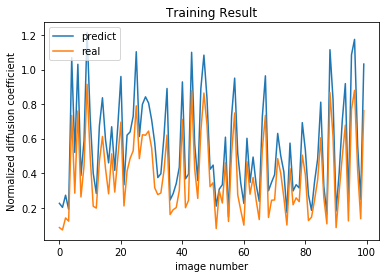

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

x=[]
for i in range(100):
    x.append(i)

pred=model.predict(X_train)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(x,pred[0:100], label='predict')
ax.plot(x,Y_train[0:100],label='real')
ax.set_title('Training Result')
ax.set_xlabel('image number')
ax.set_ylabel('Normalized diffusion coefficient')
ax.legend(loc='best')
# plt.savefig('ResNet_train.png', dpi=400)

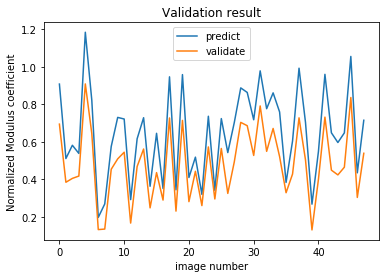

In [11]:
x=[]
for i in range(48):
    x.append(i)

pred=model.predict(X_val)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(x,pred, label='predict')
ax.plot(x,Y_val,label='validate')
ax.set_xlabel('image number')
ax.set_ylabel('Normalized Modulus coefficient')
ax.set_title('Validation result')
ax.legend(loc='best')
# plt.savefig('ResNet_prediction.png', dpi=400)

0.0076655152138810695

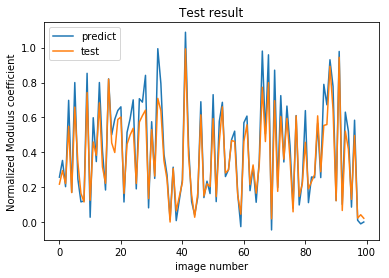

In [13]:
x=[]
for i in range(100):
    x.append(i)

pred=model.predict(X_test)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(x,pred[:100]-0.2, label='predict')
ax.plot(x,Y_test[:100],label='test')
ax.set_xlabel('image number')
ax.set_ylabel('Normalized Modulus coefficient')
ax.set_title('Test result')
ax.legend(loc='best')
# plt.savefig('ResNet_prediction.png', dpi=400)

mean_squared_error(Y_test, pred-0.2)

In [14]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 128, 128, 1)   0                                            
____________________________________________________________________________________________________
conv2d_23 (Conv2D)               (None, 64, 64, 24)    888         input_2[0][0]                    
____________________________________________________________________________________________________
batch_normalization_18 (BatchNor (None, 64, 64, 24)    96          conv2d_23[0][0]                  
____________________________________________________________________________________________________
activation_19 (Activation)       (None, 64, 64, 24)    0           batch_normalization_18[0][0]     
___________________________________________________________________________________________